In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud

import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from datetime import datetime

In [22]:
# initialize the empty dataframe
df = pd.DataFrame(columns=['URL', 'Heading', 'SubHeadings', 'Content'])

In [23]:
def get_links_from_bbc_news():
    res = requests.get('https://www.bbc.com/news')

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        top_stories_div = soup_data.find('div', class_='nw-c-top-stories--international')

        if top_stories_div:

            promo_headings = top_stories_div.find_all('a', class_=lambda x: x and 'gs-c-promo-heading' in x)

            links = [heading['href'] for heading in promo_headings]

            return links
        else:
            print("The 'nw-c-top-stories--international' div was not found on the page.")
    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [24]:
links = get_links_from_bbc_news()
len(links)

15

In [25]:
# drop duplicates
links = list(set(links))
links = [link for link in links if 'live' not in link and 'https' not in link]
links

['/news/science-environment-67363874',
 '/news/world-australia-67340905',
 '/news/world-asia-67376470',
 '/news/world-latin-america-67376145',
 '/news/world-europe-67368409',
 '/news/world-australia-67340907',
 '/news/business-67376299',
 '/news/world-us-canada-67375145',
 '/news/world-middle-east-67375667',
 '/news/entertainment-arts-67375063',
 '/news/world-us-canada-67375220']

In [26]:
# assign the links to the dataframe
df['URL'] = links
df

,URL,Heading,SubHeadings,Content
0,/news/science-environment-67363874,NaN,NaN,NaN
1,/news/world-australia-67340905,NaN,NaN,NaN
2,/news/world-asia-67376470,NaN,NaN,NaN
3,/news/world-latin-america-67376145,NaN,NaN,NaN
4,/news/world-europe-67368409,NaN,NaN,NaN
5,/news/world-australia-67340907,NaN,NaN,NaN
6,/news/business-67376299,NaN,NaN,NaN
7,/news/world-us-canada-67375145,NaN,NaN,NaN
8,/news/world-middle-east-67375667,NaN,NaN,NaN
9,/news/entertainment-arts-67375063,NaN,NaN,NaN


In [27]:
MAIN_URL = 'https://www.bbc.com'

In [28]:
def requestArticle(idx, url):
    url_to_fetch = MAIN_URL + url

    # Send an HTTP GET request to the specified URL
    res = requests.get(url_to_fetch)

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        meta = soup_data.find('meta', attrs={'property': 'article:section'})

        if meta:
            # print("Topic:", meta['content'])
            df.loc[idx, 'Topic'] = meta['content']

        # Find the <article> tag and get all elements inside it
        article = soup_data.find('article')

        if article:
            # Find all elements (tags) inside the <article> tag
            article_elements = article.find_all()
            
            # Extract the heading
            heading = article.find('h1').text
            # print("Heading")
            # print(heading)

            # Extract the subheadings
            # get headlines with data-component="subheadline-block"
            subheadings = article.find_all('div', attrs={'data-component': 'subheadline-block'})
            subheadings = [subheading for subheading in subheadings if 'You may also be interested in:' not in subheading.text]
            subheadings = [subheading.text for subheading in subheadings]
            subheadings = (', ').join(subheadings)
            # print("SubHeading")
            # print(subheadings)


            # Extract the content
            content = '\n'.join([element.text for element in article_elements if element.name == 'p'])
            # print("Content")
            # print(content)

            # Update the dataframe
            df.loc[idx, 'Heading'] = heading
            df.loc[idx, 'SubHeadings'] = subheadings
            df.loc[idx, 'Content'] = content
            df.loc[idx, 'RequestDate'] = pd.Timestamp.now()
            

        else:
            print("No <article> tag found on the page.")

    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [29]:
# Loop through the links and request each article
for idx, link in enumerate(links):
    requestArticle(idx, link)

In [30]:
def cleanText(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens] # everything lowercase
    tokens = [word.strip() for word in tokens] # strips whitespaces
    tokens = [word for word in tokens if word.isalnum()] # only alpha numerical values
    tokens = [word for word in tokens if not word in stop_words] # removes stopwords
    return tokens 

In [31]:
df.fillna('', inplace=True)
df['Cleaned_Heading'] = df['Heading'].apply(cleanText)
df['Cleaned_SubHeadings'] = df['SubHeadings'].apply(cleanText)
df['Cleaned_Content'] = df['Content'].apply(cleanText)


In [32]:
df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content
0,/news/science-environment-67363874,First ever images prove 'lost echidna' not ext...,Sacred mountains,This video can not be played\nWatch: The foota...,Science & Environment,2023-11-10 10:11:41.737660,"[first, ever, images, prove, echidna, extinct]","[sacred, mountains]","[video, played, watch, footage, proved, attenb..."
1,/news/world-australia-67340905,Johnny Ruffo: Australian singer and Home and A...,,Australian television star and singer Johnny R...,Australia,2023-11-10 10:11:41.848747,"[johnny, ruffo, australian, singer, home, away...",[],"[australian, television, star, singer, johnny,..."
2,/news/world-asia-67376470,Toxic smog chokes Pakistan and shuts cities,,Toxic smog in eastern Pakistan has made thousa...,Asia,2023-11-10 10:11:41.955261,"[toxic, smog, chokes, pakistan, shuts, cities]",[],"[toxic, smog, eastern, pakistan, made, thousan..."
3,/news/world-latin-america-67376145,Mexico officials find 123 migrants trapped in ...,,Mexican authorities have found 123 people from...,Latin America & Caribbean,2023-11-10 10:11:42.058101,"[mexico, officials, find, 123, migrants, trapp...",[],"[mexican, authorities, found, 123, people, nei..."
4,/news/world-europe-67368409,Jewish fears as German support for Israel is c...,,"Chancellor Olaf Scholz says he's ""ashamed and ...",Europe,2023-11-10 10:11:42.167890,"[jewish, fears, german, support, israel, chall...",[],"[chancellor, olaf, scholz, says, ashamed, outr..."
5,/news/world-australia-67340907,Australia offers climate refuge to Tuvalu citi...,,Australia has offered refuge to citizens of Tu...,Australia,2023-11-10 10:11:42.270120,"[australia, offers, climate, refuge, tuvalu, c...",[],"[australia, offered, refuge, citizens, tuvalu,..."
6,/news/business-67376299,Thai owner of Miss Universe goes bankrupt,,"The Thai owner of the Miss Universe pageant, w...",Business,2023-11-10 10:11:42.370115,"[thai, owner, miss, universe, goes, bankrupt]",[],"[thai, owner, miss, universe, pageant, part, f..."
7,/news/world-us-canada-67375145,US veteran gets world's first eye transplant,,This video can not be played\nWatch: World's f...,US & Canada,2023-11-10 10:11:42.472659,"[us, veteran, gets, world, first, eye, transpl...",[],"[video, played, watch, world, first, eye, tran..."
8,/news/world-middle-east-67375667,Israel officials accuse Gaza reporters of know...,More on Israel-Gaza war,Israel's communications minister has accused f...,Middle East,2023-11-10 10:11:42.582352,"[israel, officials, accuse, gaza, reporters, k...",[war],"[israel, communications, minister, accused, fo..."
9,/news/entertainment-arts-67375063,Hunger Games: Stars hit red carpet for world p...,,This video can not be played\nStars hit the re...,Entertainment & Arts,2023-11-10 10:11:42.686699,"[hunger, games, stars, hit, red, carpet, world...",[],"[video, played, stars, hit, red, carpet, new, ..."


In [33]:
# join all the tokens into a single string
df['MergedText'] = df['Cleaned_Heading'] + df['Cleaned_SubHeadings'] + df['Cleaned_Content']
df['MergedText'] = df['MergedText'].apply(lambda x: ' '.join(x))

df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content,MergedText
0,/news/science-environment-67363874,First ever images prove 'lost echidna' not ext...,Sacred mountains,This video can not be played\nWatch: The foota...,Science & Environment,2023-11-10 10:11:41.737660,"[first, ever, images, prove, echidna, extinct]","[sacred, mountains]","[video, played, watch, footage, proved, attenb...",first ever images prove echidna extinct sacred...
1,/news/world-australia-67340905,Johnny Ruffo: Australian singer and Home and A...,,Australian television star and singer Johnny R...,Australia,2023-11-10 10:11:41.848747,"[johnny, ruffo, australian, singer, home, away...",[],"[australian, television, star, singer, johnny,...",johnny ruffo australian singer home away actor...
2,/news/world-asia-67376470,Toxic smog chokes Pakistan and shuts cities,,Toxic smog in eastern Pakistan has made thousa...,Asia,2023-11-10 10:11:41.955261,"[toxic, smog, chokes, pakistan, shuts, cities]",[],"[toxic, smog, eastern, pakistan, made, thousan...",toxic smog chokes pakistan shuts cities toxic ...
3,/news/world-latin-america-67376145,Mexico officials find 123 migrants trapped in ...,,Mexican authorities have found 123 people from...,Latin America & Caribbean,2023-11-10 10:11:42.058101,"[mexico, officials, find, 123, migrants, trapp...",[],"[mexican, authorities, found, 123, people, nei...",mexico officials find 123 migrants trapped tra...
4,/news/world-europe-67368409,Jewish fears as German support for Israel is c...,,"Chancellor Olaf Scholz says he's ""ashamed and ...",Europe,2023-11-10 10:11:42.167890,"[jewish, fears, german, support, israel, chall...",[],"[chancellor, olaf, scholz, says, ashamed, outr...",jewish fears german support israel challenged ...
5,/news/world-australia-67340907,Australia offers climate refuge to Tuvalu citi...,,Australia has offered refuge to citizens of Tu...,Australia,2023-11-10 10:11:42.270120,"[australia, offers, climate, refuge, tuvalu, c...",[],"[australia, offered, refuge, citizens, tuvalu,...",australia offers climate refuge tuvalu citizen...
6,/news/business-67376299,Thai owner of Miss Universe goes bankrupt,,"The Thai owner of the Miss Universe pageant, w...",Business,2023-11-10 10:11:42.370115,"[thai, owner, miss, universe, goes, bankrupt]",[],"[thai, owner, miss, universe, pageant, part, f...",thai owner miss universe goes bankrupt thai ow...
7,/news/world-us-canada-67375145,US veteran gets world's first eye transplant,,This video can not be played\nWatch: World's f...,US & Canada,2023-11-10 10:11:42.472659,"[us, veteran, gets, world, first, eye, transpl...",[],"[video, played, watch, world, first, eye, tran...",us veteran gets world first eye transplant vid...
8,/news/world-middle-east-67375667,Israel officials accuse Gaza reporters of know...,More on Israel-Gaza war,Israel's communications minister has accused f...,Middle East,2023-11-10 10:11:42.582352,"[israel, officials, accuse, gaza, reporters, k...",[war],"[israel, communications, minister, accused, fo...",israel officials accuse gaza reporters knowing...
9,/news/entertainment-arts-67375063,Hunger Games: Stars hit red carpet for world p...,,This video can not be played\nStars hit the re...,Entertainment & Arts,2023-11-10 10:11:42.686699,"[hunger, games, stars, hit, red, carpet, world...",[],"[video, played, stars, hit, red, carpet, new, ...",hunger games stars hit red carpet world premie...


In [34]:
def TfIdfvectorGenerator(documents_preprocessed):
    """ Taking a corpus of documents which have been preprocessed and exist in string shape, 
    creates TFIDF representations and returns the representations, and the TFIDF vectorizer"""
    from datetime import datetime
    beg = datetime.now()
    vectorizer = TfidfVectorizer(min_df=1,
                                 max_df=0.75) 
    
    tfidf = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',tfidf.shape[0])
    print('time spent:',end-beg)
    return tfidf, vectorizer

In [35]:
tfidf, vectorizer = TfIdfvectorGenerator(df['MergedText']) 

documents processed: 11
time spent: 0:00:00.009086


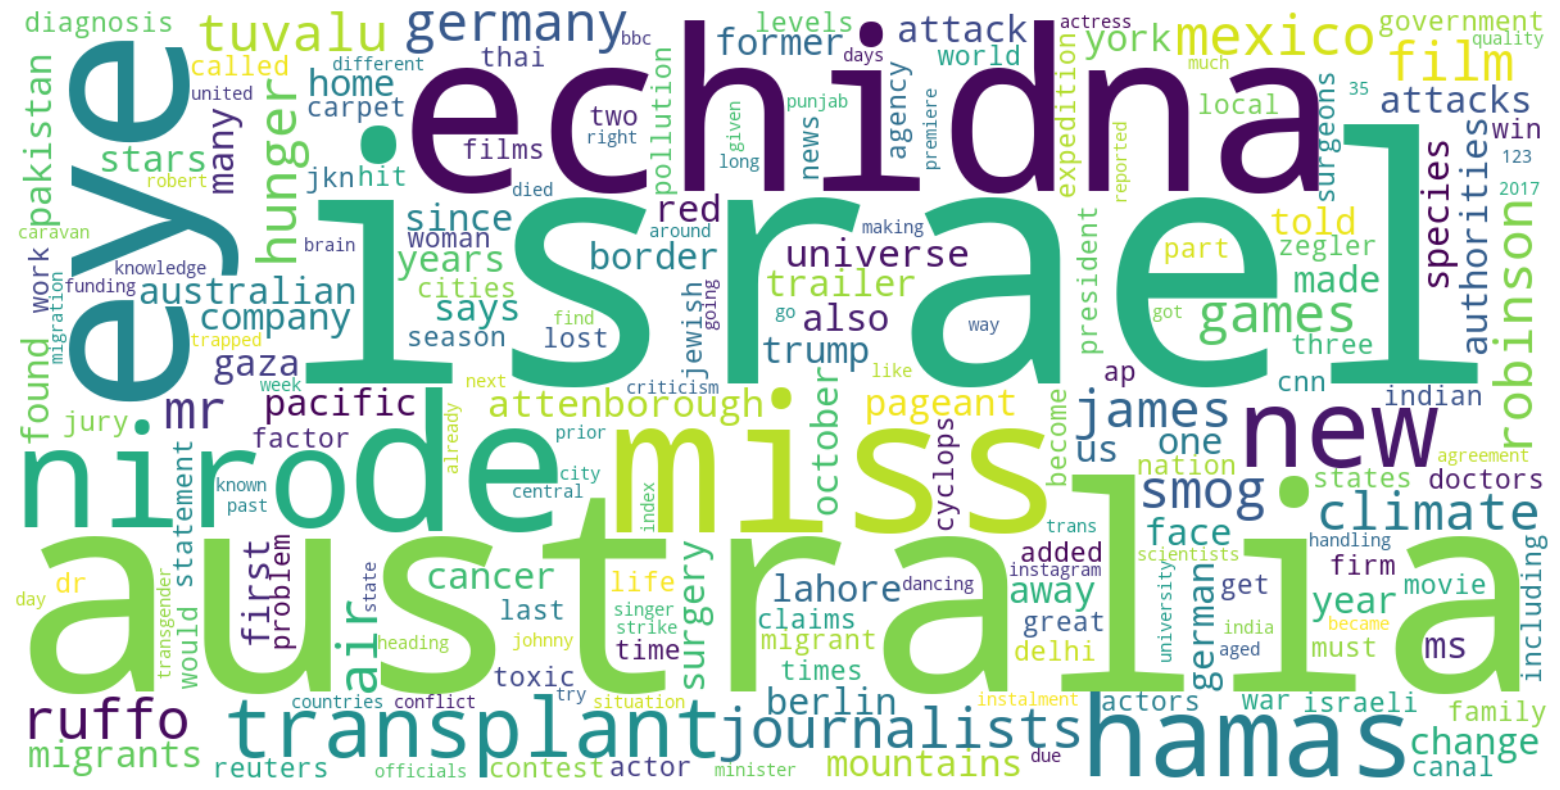

In [36]:
# Step 2: Rank words by TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each word
tfidf_scores = tfidf.sum(axis=0).A1

# Create a dictionary of words and their TF-IDF scores
word_scores = dict(zip(feature_names, tfidf_scores))

# Step 3: Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.show()
todayDate = datetime.today().strftime('%Y-%m-%d-%H%M%S')
plt.savefig('clouds/' + todayDate + '_wordcloud.png', dpi=300)

In [ ]:
import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from dotenv import load_dotenv

load_dotenv()

# create message object instance
msg = MIMEMultipart()

# setup the parameters of the message
password = os.environ.get('MAIL_PASSWORD')
msg['From'] = os.environ.get('MAIL_FROM')
msg['To'] = os.environ.get('MAIL_TO')
msg['Subject'] = "Todays WordCloud to the top news of BBC"
msg['Body'] = "Todays WordCloud to the top news of BBC, see attached image"

# attach image to message body
fp = open('clouds/' + todayDate + '_wordcloud.png', 'rb')
img = MIMEImage(fp.read())
fp.close()
msg.attach(img)

# create server
server = smtplib.SMTP(os.environ.get('MAIL_HOST'))

server.starttls()

# Login Credentials for sending the mail
server.login(os.environ.get('MAIL_USER'), password)

# send the message via the server.
server.sendmail(msg['From'], msg['To'], msg.as_string())

server.quit()

print("successfully sent email to %s:" % (msg['To']))